# Introduction to EpiConn

Welcome! This jupyter notebook carries out core analyses and visualizations for exploring the spatiotemporal dynamics of structure-function coupling in drug-resistant epilepsy. We have provided a sample dataset, and our methods can be applied to your own datasets. Input data includes 45 seizures from 9 patients (along with interictal data), and structural networks derived from HARDI tractography. Note: metrics derived from permuted data may vary slightly each time the pipeline is run due to randomization inherent to the procedure.

This serves as a supplement to our paper in submission at Brain, also available here: https://www.biorxiv.org/content/early/2018/09/04/406793. Please see paper for details on image acquisition, processing, and analysis.

# 1. Setup

Here we import some key modules and define some aesthetics

In [7]:
import pandas as pd
import scipy as sp
from IPython import display
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import csv
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from math import log
from scipy import stats
from scipy.spatial import distance
import itertools
import copy
from scipy.special import comb
import matplotlib.gridspec as gridspec
sb.set(context="poster", font_scale=1)
sb.set_style("white")

mycmap_iter = itertools.cycle(sb.color_palette("husl", n_subs))
mycmap = sb.color_palette("husl", n_subs)

# 2. Function Definitions

Here we define key functions which will be used to carry out our analysis. This includes the edge resection approach

In [8]:
def mysmoother(x, N):
    """
    smooths vector (for visualization purposes)
    """
    return np.convolve(x, np.ones((N,))/N, mode='valid')

def fisher(mymat):
    """
    fisher r to z transform on a matrix mymat
    """
    z = 0.5*np.log((1+mymat)/(1-mymat))
    return z

def lin_interp(signal,nsamples):
    """
    interpolates a signal to fit nsamples number of samples
    """
    x = np.arange(len(signal))
    xvals = np.linspace(0, len(signal), nsamples)
    sig_interp = np.interp(xvals, x, signal)
    return sig_interp

def mat2line(mymat):
    """
    converts a 2D connectivity matrix to a 1D vector
    """
    mymatline =  mymat[np.triu_indices(np.shape(mymat)[0], 1)]
    return mymatline

def line2mat(myline, n_nodes):
    """
    converts a 1D vector back to a 2D connectivity matrix 
    """
    mymat = np.zeros((n_nodes, n_nodes))
    mymat[np.triu_indices(n_nodes, 1)] = myline
    mymat = mymat + zip(*( mymat))
    return mymat

def sim(funcmatline,structmatline,mymetric):
    """
    computes SC-FC coupling between vectors derived from two connectivity matrices
    (structural and functional), based on mymetric
    """
    if mymetric == 'pearson':
        mysim = fisher(pearsonr(funcmatline,structmatline)[0] )
            
    elif mymetric == 'recruitment':         
        mysim = np.sum(funcmatline[structmatline > 0])/np.sum(funcmatline)
        
    elif mymetric =='spearman':
        mysim = fisher(spearmanr(funcmatline,structmatline)[0] )
    return mysim    

def edge_resection(structmat, funcmat,mymetric):
    """
    carries out virtual edge resection approach, using similarity metric mymetric
    """
    n_nodes = np.shape(structmat)[0]
    structmatline = mat2line(structmat)
    funcmatline = mat2line(funcmat)
    n_edges = np.shape(structmatline)[0]
    sim_orig = sim(funcmatline,structmatline, mymetric) 
    delz = np.zeros((n_edges,))
    
    for k in range(n_edges):
        new_structmatline =copy.deepcopy(structmatline[:]) 
        new_funcmatline = copy.deepcopy(funcmatline[:]) 
        new_structmatline = np.delete(new_structmatline , k)
        new_funcmatline = np.delete(new_funcmatline , k)
        delz[k] = (sim_orig - sim(new_funcmatline,new_structmatline,mymetric))*n_edges
    delzmat = line2mat(delz, n_nodes)
    return delzmat

# 3. Initializations

Here we initialize the key variables used in this pipeline. This includes the frequency bands, which are as follows:
* $\alpha$-$\theta$ (5-15 Hz), 
* $\beta$ (15-25 Hz),
* $\gamma_{low}$ (30-40 Hz),
* $\gamma_{high}$ (95-105 Hz),
* broadband (5-115 Hz with 60 Hz Notch filter)

We also define the subjects and their seizures, along with seizure times and time to generalization, if applicable. Subject data is included in this github repository, and raw data is available at the IEEG Portal (ieeg.org)


In [9]:
freq_bands = ['all_adj_broadband_CC','all_adj_alphatheta','all_adj_beta','all_adj_lowgamma','all_adj_highgamma']
freq_titles = ['broadband','alphatheta','beta','lowgamma','highgamma']
freq_titles_symbols = ['$\\alpha$-$\\theta$','$\\beta$','$\gamma_{low}$','$\gamma_{high}$']
freq_titles_symbols_BB = ['broadband','$\\alpha$-$\\theta$','$\\beta$','$\gamma_{low}$','$\gamma_{high}$']

subjects=['HUP094','HUP105','HUP106','HUP107','HUP111B','HUP081','HUP093','HUP119','HUP126']
ictals = [[1,2,3],[1,2],[1,2,3,4],[2,3,4,5,6,7],[18,19,20,21,22] ,[1,2,3,4], [2,4,5,6,8,9] , [1,2,3,4,5],[1,2.1,2.2,2.3,4,5.1,5.2,5.3,6.1,6.2]]
times = [[73,62,113],[52,76],[101,83,88,107],[80,161,84,64,59,27],[63,71,76,63,86] ,[172,131,154,133], [31,29,34,38,30,33] , [47,61,18,142,92],[29,31,28,43,59,31,52,44,48,33]]

sub_assignment = [1,1,1,2,2,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,6,6,6,6,7,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9]
is_generalized = [1,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
time_to_generalization = [32,24,70,31,32,24,0,43,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
n_subs = len(subjects)

regress_distance = 'no'
mymetric = 'pearson'

permiters=100 # number of random permutations for null model -- lowered here to speed up processing time
n_samples = 200 # n for resampling to same seizure length     

junk,sz_idxs = np.unique(sub_assignment,return_index=True)
sz_idxs = np.append(sz_idxs,len(sub_assignment))
all_sz_idxs = np.arange(len(sub_assignment))

r_pre_mean = np.zeros((len(sub_assignment),len(freq_bands)))
r_ictal_mean = np.zeros((len(sub_assignment),len(freq_bands)))
r_ictal_mean_pregen = np.zeros((len(sub_assignment),len(freq_bands)))
r_ictal_mean_postgen = np.zeros((len(sub_assignment),len(freq_bands)))

rand_r_pre_mean = np.zeros((len(sub_assignment),permiters,len(freq_bands)))
rand_r_ictal_mean = np.zeros((len(sub_assignment),permiters,len(freq_bands)))

r_interictal_mean =  np.zeros((len(sub_assignment),len(freq_bands)))
rand_r_interictal_mean =  np.zeros((len(sub_assignment),permiters,len(freq_bands)))

structmat_dict = {}
mean_rscore_diff_dict = {}
mean_rscore_ictal_dict = {}
mean_rscore_pre_dict = {}
electrodes_dict = {}
r_temporal_dict = {}
gs_temporal_dict = {}
r_rand_temporal_dict = {}
   
sz_ct=-1 
sz_ct_interictal=-1 

# 4. Data Processing

We import the structural and functional data, and carry out the bulk of the processing (computing SC-FC coupling for each seizure during interictal, preictal, ictal periods, and edge resection analysis). Note that "rscore" here refers to the contribution of each edge on the SC-FC coupling value (which here is quantified via a pearson r)

In [10]:
for sub_idx, subject in enumerate(subjects):
    print subject,
    
    # IMPORT STRUCTURAL DATA
    structmat = sio.loadmat('../Data/' + subject + '/structural.mat')['structmat'] 
    distmat = sio.loadmat('../Data/' + subject + '/structural.mat')['eucl_dist']    
    structmat[structmat <= 0] = 0
    log_structmat = np.log10(structmat+1)
    structmat_dict[sub_idx] = log_structmat
    
    # IMPORT NODE LABELS
    mylabels = []
    label_fn = '../Data/' + subject + '/' + subject + '_node_labels.csv'
    with open(label_fn) as csvDataFile:
        csvReader = csv.reader(csvDataFile)
        for row in csvReader:
            mylabels.append(row[0])
    electrodes_dict[sub_idx] = mylabels   
    n_elecs = len(mylabels)
    
    # Option for regressing out distance
    structmatline = mat2line(log_structmat)
    distmatline = mat2line(distmat)
    if regress_distance == 'yes':
        slope, intercept, r_value, p_value, std_err = stats.linregress(distmatline,structmatline)
        structmatline = structmatline - slope*(distmatline) - intercept

    # generate random permutations by permuting structural edges (equivalent to permuting functional edges)    
    rand_structmatlines = np.zeros((permiters,np.size(structmatline)))
    for permiter in range(permiters):
        perm_ind = np.random.permutation(range(np.size(structmatline)))
        rand_structmatlines[permiter,:] = structmatline[perm_ind]
        rand_structmatlines[permiter,:] = rand_structmatlines[permiter,:] / np.sum(rand_structmatlines[permiter,:])
       
    # load seizure-specific data
    r_temporal = np.zeros((len(ictals[sub_idx]),len(freq_bands),n_samples))
    r_rand_temporal = np.zeros((len(ictals[sub_idx]),len(freq_bands),n_samples))
    gs_temporal = np.zeros((len(ictals[sub_idx]),len(freq_bands),n_samples))
    
    for sz_idx, sz_num in enumerate(ictals[sub_idx]):
        print "ictal:",
        sz_ct=sz_ct+1  
        print sz_ct,
        adj_fn = '../Data/' + subject +'/' + subject + '.Seizure.' + str(sz_num) + '.multiband.npz'
        adj_file = np.load(adj_fn )
        n = np.shape(adj_file['all_adj_broadband_CC'])[2]   
        
        for idx, freq in enumerate(freq_bands):                  
            all_adj = adj_file[freq]
            
            # spot treat artifact    
            if subject == "HUP081" and sz_num == 3:
                all_adj[:,:,176] = (all_adj[:,:,175] + all_adj[:,:,177])/2.0
                    
            gs = np.zeros((n,len(freq_bands)))         
            r = np.zeros((n,len(freq_bands)))
            rand_r = np.zeros((n,permiters,len(freq_bands)))         
   
            for i in range(n):  
                gs[i,idx] = np.sum(all_adj[:,:,i])/(len(electrodes_dict[sub_idx])*len(electrodes_dict[sub_idx]))      
                funcmatline = mat2line(all_adj[:,:,i])                         
                r[i,idx] =sim(funcmatline,structmatline,mymetric) 
             
                # null model
                for permiter in range(permiters):
                    rand_structmatline = rand_structmatlines[permiter,:]
                    rand_r[i,permiter,idx] = sim(funcmatline,rand_structmatline, mymetric)
            
            # In generalized seizures, only consider the time prior to generalization
            if is_generalized[sz_ct] == 1:
                n_pre_gen = time_to_generalization[sz_ct] * 2
            else:
                n_pre_gen = n
            
            # do seizure-level edge-resection
            funcmat_pre = np.mean(all_adj[:,:,0:n/2],axis=2)
            funcmat_ictal = np.mean(all_adj[:,:,n/2:(n/2 +n_pre_gen/2)],axis=2)
            rscore_pre = edge_resection(log_structmat, funcmat_pre,mymetric)
            rscore_ictal = edge_resection(log_structmat, funcmat_ictal,mymetric)
            rscore_diff = rscore_ictal - rscore_pre    
            
            mean_rscore_diff_dict[sub_idx,sz_idx,idx] = rscore_diff
            mean_rscore_ictal_dict[sub_idx,sz_idx,idx] = rscore_ictal
            mean_rscore_pre_dict[sub_idx,sz_idx,idx] = rscore_pre       
    
            r_pre_mean[sz_ct, idx] = np.mean(r[0:n/2,idx])
            r_ictal_mean[sz_ct, idx]=np.mean(r[n/2:n,idx])
            
            if is_generalized[sz_ct] == 1:
                r_ictal_mean_pregen[sz_ct, idx]=np.mean(r[n/2:(n/2+n_pre_gen/2),idx])
                r_ictal_mean_postgen[sz_ct, idx]=np.mean(r[(n/2+n_pre_gen/2):,idx])
            else:
                r_ictal_mean_pregen[sz_ct, idx]=np.mean(r[n/2:n,idx])
                r_ictal_mean_postgen[sz_ct, idx]=np.mean(r[n/2:n,idx])

            rand_r_pre_mean[sz_ct, :,idx]=np.mean(rand_r[n/2:n,:,idx],axis=0)
            rand_r_ictal_mean[sz_ct,:, idx]=np.mean(rand_r[n/2:n,:,idx],axis=0)
            
            r_temporal[ sz_idx, idx,:] = lin_interp(r[:,idx],n_samples)
            r_rand_temporal[ sz_idx, idx,:] = lin_interp(np.mean(rand_r[:,:,idx],axis=1),n_samples)
            gs_temporal[ sz_idx, idx,:] = lin_interp(gs[:,idx],n_samples)
            
        r_temporal_dict[sub_idx] = r_temporal
        r_rand_temporal_dict[sub_idx] = r_rand_temporal
        gs_temporal_dict[sub_idx] = gs_temporal 

    # interictal
    print "interictal:",
    adj_fn = '../Data/' + subject +'/' + subject + '.Seizure.' + '1000' + '.multiband.npz'
    adj_file = np.load(adj_fn )  
    num_sz = len(ictals[sub_idx])
    
    # choose interictal intervals of same length as seizures
    len_inter = np.shape(adj_file['all_adj_broadband_CC'])[2]   
    intervals = range(0,len_inter,max(times[sub_idx]))
    start_times = np.random.choice(intervals[:-1],num_sz,replace=False)

    for mynum_sz in range(num_sz):
        len_sz = times[sub_idx][mynum_sz]
        sz_ct_interictal=sz_ct_interictal+1
        print sz_ct_interictal,
        for idx, freq in enumerate(freq_bands):      
            gs = np.zeros((len_sz,len(freq_bands)))         
            r = np.zeros((len_sz,len(freq_bands)))
            rand_r = np.zeros((len_sz,permiters,len(freq_bands)))         
            all_adj = adj_file[freq]
            
            for i,myval in enumerate(range(start_times[mynum_sz], start_times[mynum_sz]+len_sz)):          
                gs[i,idx] = np.sum(all_adj[:,:,myval])         
                funcmatline = mat2line(all_adj[:,:,myval])                
                r[i,idx] = sim(funcmatline,structmatline,mymetric) 
               
                # null model
                for permiter in range(permiters):
                    rand_structmatline = rand_structmatlines[permiter,:]
                    rand_r[i,permiter,idx] = sim(funcmatline,rand_structmatline,mymetric)
                    
            r_interictal_mean[sz_ct_interictal, idx]  = np.mean(r[:,idx],axis=0)       
            rand_r_interictal_mean[sz_ct_interictal, :,idx] = np.mean(rand_r[:,:,idx],axis=0)

HUP094 ictal: 0 ictal: 1 ictal: 2 interictal: 0 1 2 HUP105 ictal: 3 ictal: 4 interictal: 3 4 HUP106 ictal: 5 ictal: 6 ictal: 7 ictal: 8 interictal: 5 6 7 8 HUP107 ictal: 9 ictal: 10 ictal: 11 ictal: 12 ictal: 13 ictal: 14 interictal: 9 10 11 12 13 14 HUP111B ictal: 15 ictal: 16 ictal: 17 ictal: 18 ictal: 19 interictal: 15 16 17 18 19 HUP081 ictal: 20 ictal: 21 ictal: 22 ictal: 23 interictal: 20 21 22 23 HUP093 ictal: 24 ictal: 25 ictal: 26 ictal: 27 ictal: 28 ictal: 29 interictal: 24 25 26 27 28 29 HUP119 ictal: 30 ictal: 31 ictal: 32 ictal: 33 ictal: 34 interictal: 30 31 32 33 34 HUP126 ictal: 35 ictal: 36 ictal: 37 ictal: 38 ictal: 39 ictal: 40 ictal: 41 ictal: 42 ictal: 43 ictal: 44 interictal: 35 36 37 38 39 40 41 42 43 44


In [13]:
preictal_all = np.concatenate([np.array(r_pre_mean[:,0]),np.array(r_pre_mean[:,1]),np.array(r_pre_mean[:,2]),np.array(r_pre_mean[:,3]),np.array(r_pre_mean[:,4])])
ictal_all = np.concatenate([np.array(r_ictal_mean[:,0]),np.array(r_ictal_mean[:,1]),np.array(r_ictal_mean[:,2]),np.array(r_ictal_mean[:,3]),np.array(r_ictal_mean[:,4])])
interictal_all = np.concatenate([np.array(r_interictal_mean[:,0]),np.array(r_interictal_mean[:,1]),np.array(r_interictal_mean[:,2]),np.array(r_interictal_mean[:,3]),np.array(r_interictal_mean[:,4])])
diff_all = (ictal_all - preictal_all)
df_ictal_freq = pd.DataFrame({"Interictal":interictal_all,"Preictal":preictal_all,"Ictal":ictal_all,"Diff":diff_all,"Subject":np.squeeze(np.matlib.repmat(np.array(sub_assignment),1,5)),"Frequency": np.repeat(freq_titles_symbols_BB,len(sub_assignment))})
melted = pd.melt(df_ictal_freq, id_vars=["Frequency","Subject"],var_name="TimePeriod", value_name="z")

# 5. Streamline Length Distributions

We can visualize the distribution of streamline lengths (and max lengths) for each subject. Note that this will be influenced by the electrode placements, given that we are only considering structural edges that connect ROIs covered by electrodes

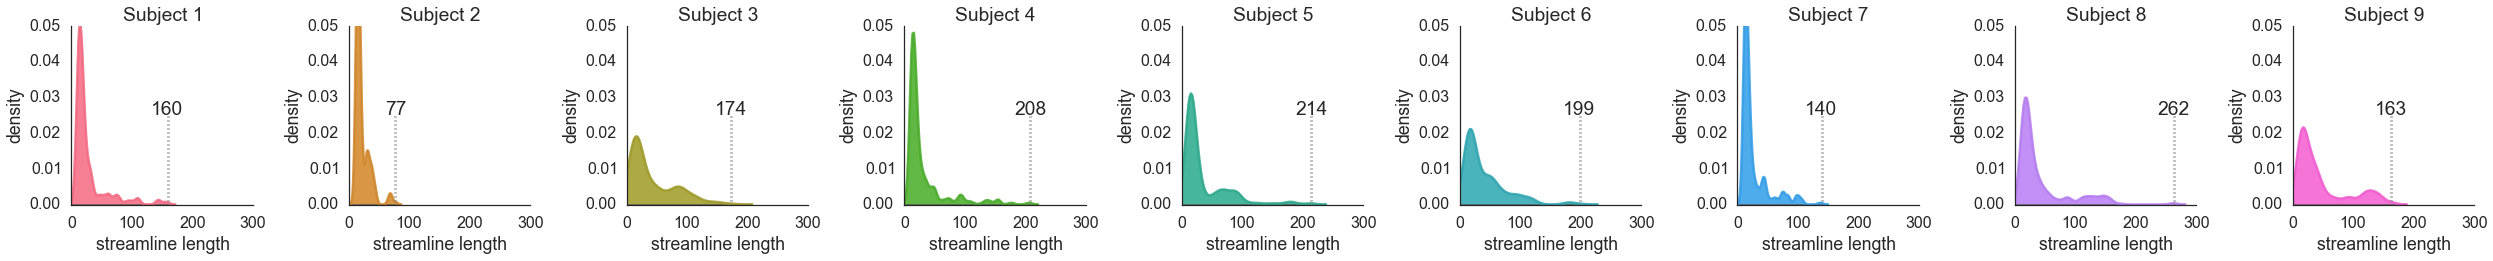

In [14]:
plt.figure(1,figsize=(35,4))
for sub_idx, subject in enumerate(subjects):

    lengthmatline = mat2line(sio.loadmat('../Data/' + subjects[sub_idx] + '/structural.mat')['lengthmat'])
    structmatline = mat2line(sio.loadmat('../Data/' + subjects[sub_idx] + '/structural.mat')['structmat'])
    plt.subplot(1,n_subs,sub_idx+1)
    ax = sb.distplot(lengthmatline[structmatline > 0],hist=False,color=next(mycmap_iter),kde_kws={"alpha":.9,"shade": True})
    max_streamline_length = np.max(lengthmatline[structmatline > 0])
    
    ymin = 0
    ymax = 0.05
    ax.set_ylim(ymin, ymax)  
    ax.set_xlim(0, 300) 
    ax.locator_params(axis='x', nbins=4)
    plt.plot([max_streamline_length,max_streamline_length],[ymin,ymax/2],'grey',linestyle='dotted' ) 
    plt.text(np.ceil(max_streamline_length),  ymax/2, "%d" % np.ceil(max_streamline_length),  horizontalalignment='center')
    plt.ylabel('density')
    plt.xlabel('streamline length')
    plt.title('Subject ' + str(sub_idx+1))
    
sb.despine()    
plt.tight_layout()    

# 6. SC-FC coupling using broadband functional connectivity

To assess the overall temporal patterns of SC-FC coupling changes during seizures, we first quantified SC-FC correlations using broadband functional connectivity networks. For each individual seizure event, we determined the degree of SC-FC coupling, as measured by z (i.e. a Fisher transformed Pearson r). 


For all seizures in all subjects, SC-FC coupling was significantly greater than chance during interictal, preictal and ictal periods.

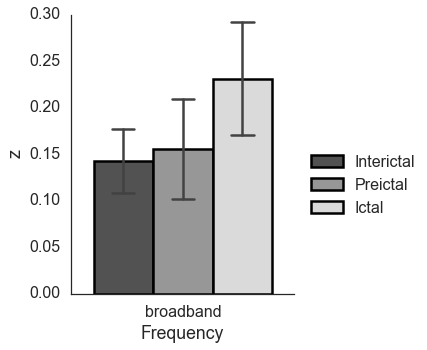

In [15]:
# Mean SC-FC coupling during the interictal, Pre-ictal, and ictal periods
plt.figure(figsize=(4,5))
sb.barplot(data=melted[melted.Frequency == 'broadband'],x='Frequency',y='z',hue_order=["Interictal","Preictal","Ictal"],hue='TimePeriod',capsize=.1,linewidth=2.5,errwidth=2.5,ci='sd',palette = sb.color_palette("Greys_r", 3))
lgd = plt.legend(bbox_to_anchor=(1.6, .55))
sb.despine()

While the temporal progression of SC-FC changes was subject-specific, there was a consistent increase between preictal and ictal periods. 

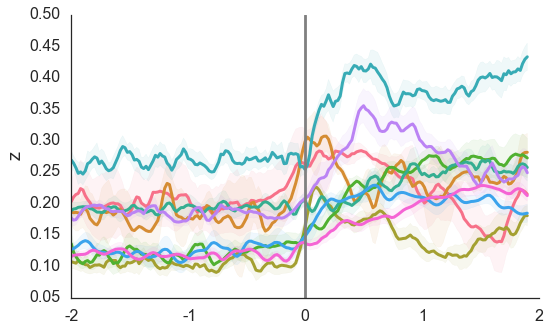

In [16]:
# Temporal progression of SC-FC coupling from preictal to ictal periods
smooth = 5
plt.figure(figsize=(8,5))
freq_idx = 0
for sub_idx, subject in enumerate(subjects[0:9]):

    mysig = (r_temporal_dict[sub_idx][:, freq_idx,:]) 
    p = plt.plot(mysmoother(np.mean(mysig,axis=0),smooth),linewidth=3.,color=next(mycmap_iter),alpha=1)
    color = p[0].get_color()   
    plt.fill_between(range(n_samples-smooth+1), mysmoother(np.mean(mysig,axis=0)-sp.stats.sem(mysig,axis=0),smooth) , mysmoother(np.mean(mysig,axis=0)+sp.stats.sem(mysig,axis=0),smooth),  alpha = 0.08,color=color,interpolate=True) #,edgecolor='k'     
    plt.ylabel('z')   
ymin, ymax = plt.ylim()  
plt.plot([n_samples/2,n_samples/2],[ymin, ymax],'grey' )  
locs, labels = plt.xticks()
plt.xticks(locs, ('-2', '-1','0', '1',  '2'))

plt.tight_layout()
sb.despine()


Per-seizure paired differences in mean z values reveal significantly greater SC-FC correlation during ictal periods than preictal periods. This effect was maintained when substituting preictal periods with randomly chosen interictal clips of equivalent duration at least 6 hours away from seizure activity. Moreover, there were no significant differences between preictal and interictal period SC-FC correlation values 

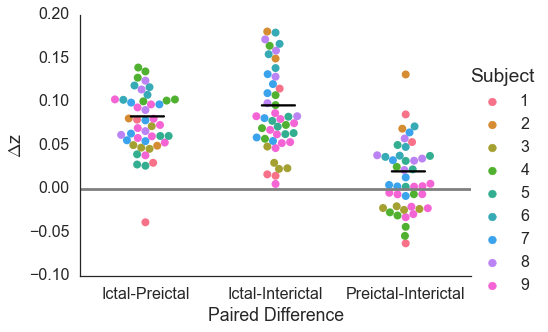

In [22]:
# Per-seizure paired differences in mean z values

freq_idx=0
freq = freq_bands[freq_idx]
plt.figure(figsize=(7,5))
df_ictal  =pd.DataFrame({"Ictal-Preictal":np.array(r_ictal_mean[:,freq_idx])-np.array(r_pre_mean[:,freq_idx]), "Ictal-Interictal":np.array(r_ictal_mean[:,freq_idx])-np.array(r_interictal_mean[:,freq_idx]), "Preictal-Interictal":np.array(r_pre_mean[:,freq_idx])-np.array(r_interictal_mean[:,freq_idx]),"Subject":np.array(sub_assignment)})
df_ictal = pd.melt(df_ictal, "Subject", var_name="Paired Difference")
sb.stripplot(data=([np.mean(np.array(r_ictal_mean[:,freq_idx]) - np.array(r_pre_mean[:,freq_idx]) )],[np.mean(np.array(r_ictal_mean[:,freq_idx]) - np.array(r_interictal_mean[:,freq_idx]) ) ],[np.mean(np.array(r_pre_mean[:,freq_idx]) - np.array(r_interictal_mean)[:,freq_idx] ) ] ),size=40 ,color='k',marker="$-$",zorder=1)
axes= sb.swarmplot(data=df_ictal,x="Paired Difference",y="value",size=8,hue="Subject",order=["Ictal-Preictal", "Ictal-Interictal","Preictal-Interictal"],palette=mycmap,zorder=0)
axes.axhline(y=0, xmin=0, xmax=1,color='grey')
lgd = plt.legend(bbox_to_anchor=(1.2, .85),title='Subject')
plt.ylabel('$\Delta$z')
sb.despine()
plt.tight_layout()

# 7.  SC-FC sub-analysis in focal to bilateral tonic-clonic seizures

We observed that in patients who experienced focal to bilateral tonic-clonic (FBTC) seizures (subjects 1-3), there was a drop in SC-FC coupling after the initial rise following seizure onset. 

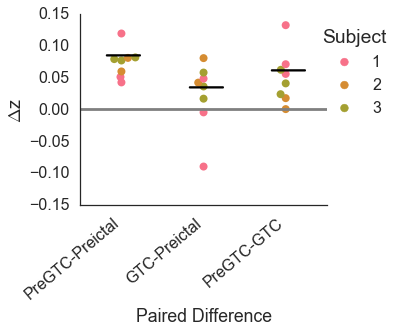

In [18]:
freq_idx=0
freq = freq_bands[freq_idx]
plt.figure(figsize=(5,5))
df_ictal  =pd.DataFrame({"PreGTC-GTC":np.array(r_ictal_mean_pregen[np.array(is_generalized) == 1,freq_idx])-np.array(r_ictal_mean_postgen[np.array(is_generalized) == 1,freq_idx]),"PreGTC-Preictal":np.array(r_ictal_mean_pregen[np.array(is_generalized) == 1,freq_idx])-np.array(r_pre_mean[np.array(is_generalized) == 1,freq_idx]), "GTC-Preictal":np.array(r_ictal_mean_postgen[np.array(is_generalized) == 1,freq_idx])-np.array(r_pre_mean[np.array(is_generalized) == 1,freq_idx]),"Subject":np.array(sub_assignment)[np.array(is_generalized) == 1]})
df_ictal = pd.melt(df_ictal, "Subject", var_name="Paired Difference")
sb.stripplot(data=([np.mean(np.array(r_ictal_mean_pregen[np.array(is_generalized) == 1,freq_idx]) - np.array(r_pre_mean[np.array(is_generalized) == 1,freq_idx]) )],[np.mean(np.array(r_ictal_mean_postgen[np.array(is_generalized) == 1,freq_idx]) - np.array(r_pre_mean[np.array(is_generalized) == 1,freq_idx]) ) ],[np.mean(np.array(r_ictal_mean_pregen[np.array(is_generalized) == 1,freq_idx]) - np.array(r_ictal_mean_postgen[np.array(is_generalized) == 1,freq_idx]) )]),size=40 ,color='k',marker="$-$",zorder=1)
axes= sb.swarmplot(data=df_ictal,x="Paired Difference",y="value",size=8,hue="Subject",order=["PreGTC-Preictal","GTC-Preictal", "PreGTC-GTC"],palette=mycmap,zorder=0)
axes.axhline(y=0, xmin=0, xmax=1,color='grey')
lgd = plt.legend(bbox_to_anchor=(1.3, 1),title='Subject')
plt.ylabel('$\Delta$z')
sb.despine()
plt.xticks(rotation=40,ha='right')
plt.tight_layout()

# 8. Frequency-specific SC-FC analysis


To better understand the frequency dependence of the observed increase in SC-FC coupling during seizures, we repeated the SC-FC coupling analysis across four frequency bands (α/θ, β, low-γ, and high-γ). 


Similar to the previous analysis, we found that the extent of SC-FC coupling was significantly greater than chance at all time points during preictal and ictal periods for all frequency bands. 

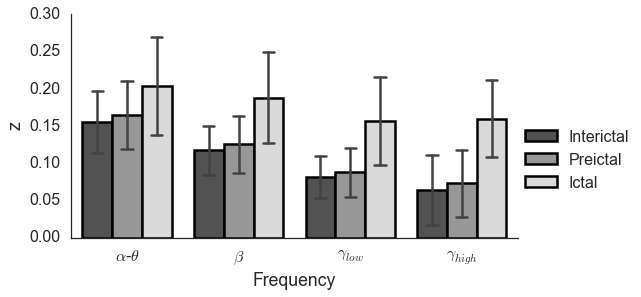

In [23]:
plt.figure(figsize=(8,4))
sb.barplot(data=melted[melted.Frequency != 'broadband'],x='Frequency',y='z',hue_order=["Interictal","Preictal","Ictal"],hue='TimePeriod',capsize=.1,linewidth=2.5,errwidth=2.5,ci='sd',palette = sb.color_palette("Greys_r", 3))
lgd = plt.legend(bbox_to_anchor=(1.28, .55))
sb.despine()

Moreover, while the preictal SC-FC was lower in higher frequency bands, the increase in SC-FC coupling between preictal and ictal periods was significant across all frequency bands.

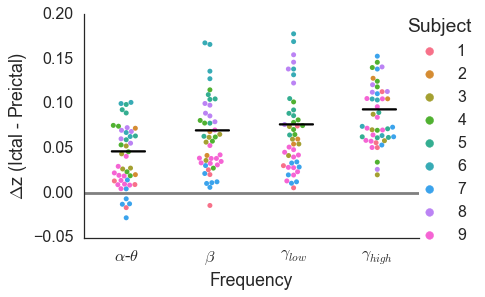

In [28]:
plt.figure(figsize=(6,4))
fg = sb.stripplot(data=(np.ndarray.tolist(np.expand_dims((np.mean(np.array(r_ictal_mean) - np.array(r_pre_mean),axis=0)),1)))[1:],size=40,color='k',marker="$-$",zorder=1)
sb.swarmplot(data=df_ictal_freq[melted.Frequency != 'broadband'],x='Frequency',y='Diff',hue='Subject',palette = mycmap,zorder=0)
fg.axhline(y=0, xmin=0, xmax=1,color='grey')
lgd = plt.legend(bbox_to_anchor=(1.2, 1.05),title='Subject')
plt.ylabel('$\Delta$z (Ictal - Preictal)')
sb.despine()


Similar to the findings with broadband functional connectivity, the findings were consistent when substituting preictal periods with interictal periods.

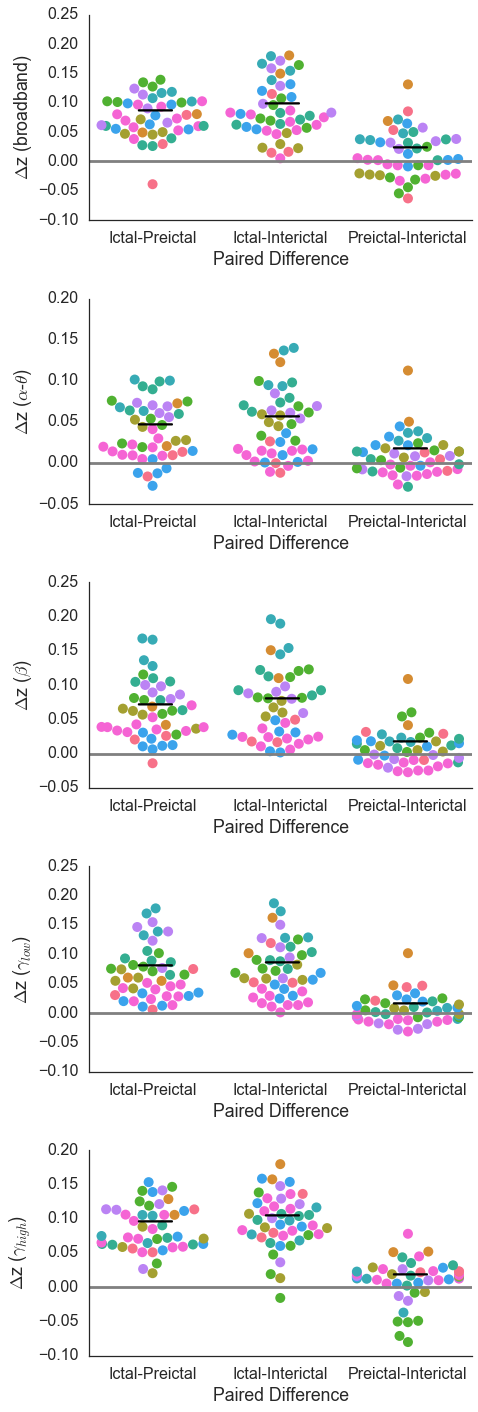

In [30]:
sb.set(context="poster", font_scale=1)
sb.set_style("white")
plt.figure(figsize=(7,20))
for freq_idx, freq in enumerate(freq_bands):
    plt.subplot(5,1,freq_idx+1) 
    df_ictal  =pd.DataFrame({"Ictal-Preictal":np.array(r_ictal_mean[:,freq_idx])-np.array(r_pre_mean[:,freq_idx]), "Ictal-Interictal":np.array(r_ictal_mean[:,freq_idx])-np.array(r_interictal_mean[:,freq_idx]), "Preictal-Interictal":np.array(r_pre_mean[:,freq_idx])-np.array(r_interictal_mean[:,freq_idx]),"Subject":np.array(sub_assignment)})
    df_ictal = pd.melt(df_ictal, "Subject", var_name="Paired Difference")
    sb.stripplot(data=([np.mean(np.array(r_ictal_mean[:,freq_idx]) - np.array(r_pre_mean[:,freq_idx]) )],[np.mean(np.array(r_ictal_mean[:,freq_idx]) - np.array(r_interictal_mean[:,freq_idx]) ) ],[np.mean(np.array(r_pre_mean[:,freq_idx]) - np.array(r_interictal_mean)[:,freq_idx] ) ] ),size=40 ,color='k',marker="$-$",zorder=1)
    axes= sb.swarmplot(data=df_ictal,x="Paired Difference",y="value",size=10,hue="Subject",order=["Ictal-Preictal", "Ictal-Interictal","Preictal-Interictal"],palette=mycmap,zorder=0)
    axes.axhline(y=0, xmin=0, xmax=1,color='grey')
    plt.ylabel('$\Delta$z (' + freq_titles_symbols_BB[freq_idx] + ')')
    sb.despine()
    axes.legend_.remove()
plt.tight_layout()

We noted that while the increase was significant across all frequency bands, there were subject-specific frequency-dependent changes in SC-FC correlation.

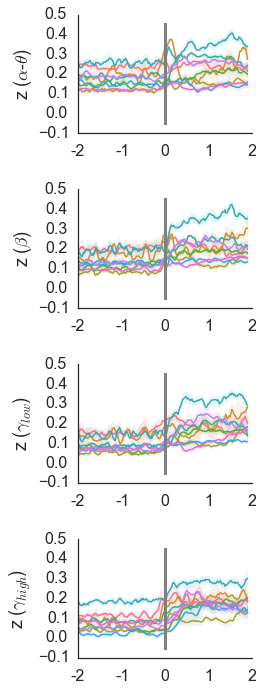

In [24]:
ymin=-0.05
ymax=.45
smooth = 5
plt.figure(figsize=(4,10))
for freq_idx, freq in enumerate(freq_bands[1:]):
    plt.subplot(4,1,freq_idx+1) 
    palette = itertools.cycle(sb.color_palette("husl", 6))
    for sub_idx, subject in enumerate(subjects):
        mysig = (r_temporal_dict[sub_idx][:, freq_idx+1,:])
        p = plt.plot(mysmoother(np.mean(mysig ,axis=0),smooth),linewidth=1.5,color=next(mycmap_iter),alpha=1)
        color = p[0].get_color()   
        plt.fill_between(range(n_samples-smooth+1), mysmoother(np.mean(mysig ,axis=0)-sp.stats.sem(mysig ,axis=0),smooth) , mysmoother(np.mean(mysig ,axis=0)+sp.stats.sem(mysig ,axis=0),smooth),  alpha = 0.1,color=color,interpolate=True) #,edgecolor='k'     
        plt.ylabel('z (' + freq_titles_symbols_BB[freq_idx+1] + ')')   
        plt.plot([n_samples/2,n_samples/2],[ymin, ymax],'grey' )  
        locs, labels = plt.xticks()
        plt.xticks(locs, ('-2', '-1','0', '1',  '2'))       
    plt.tight_layout()
    sb.despine()

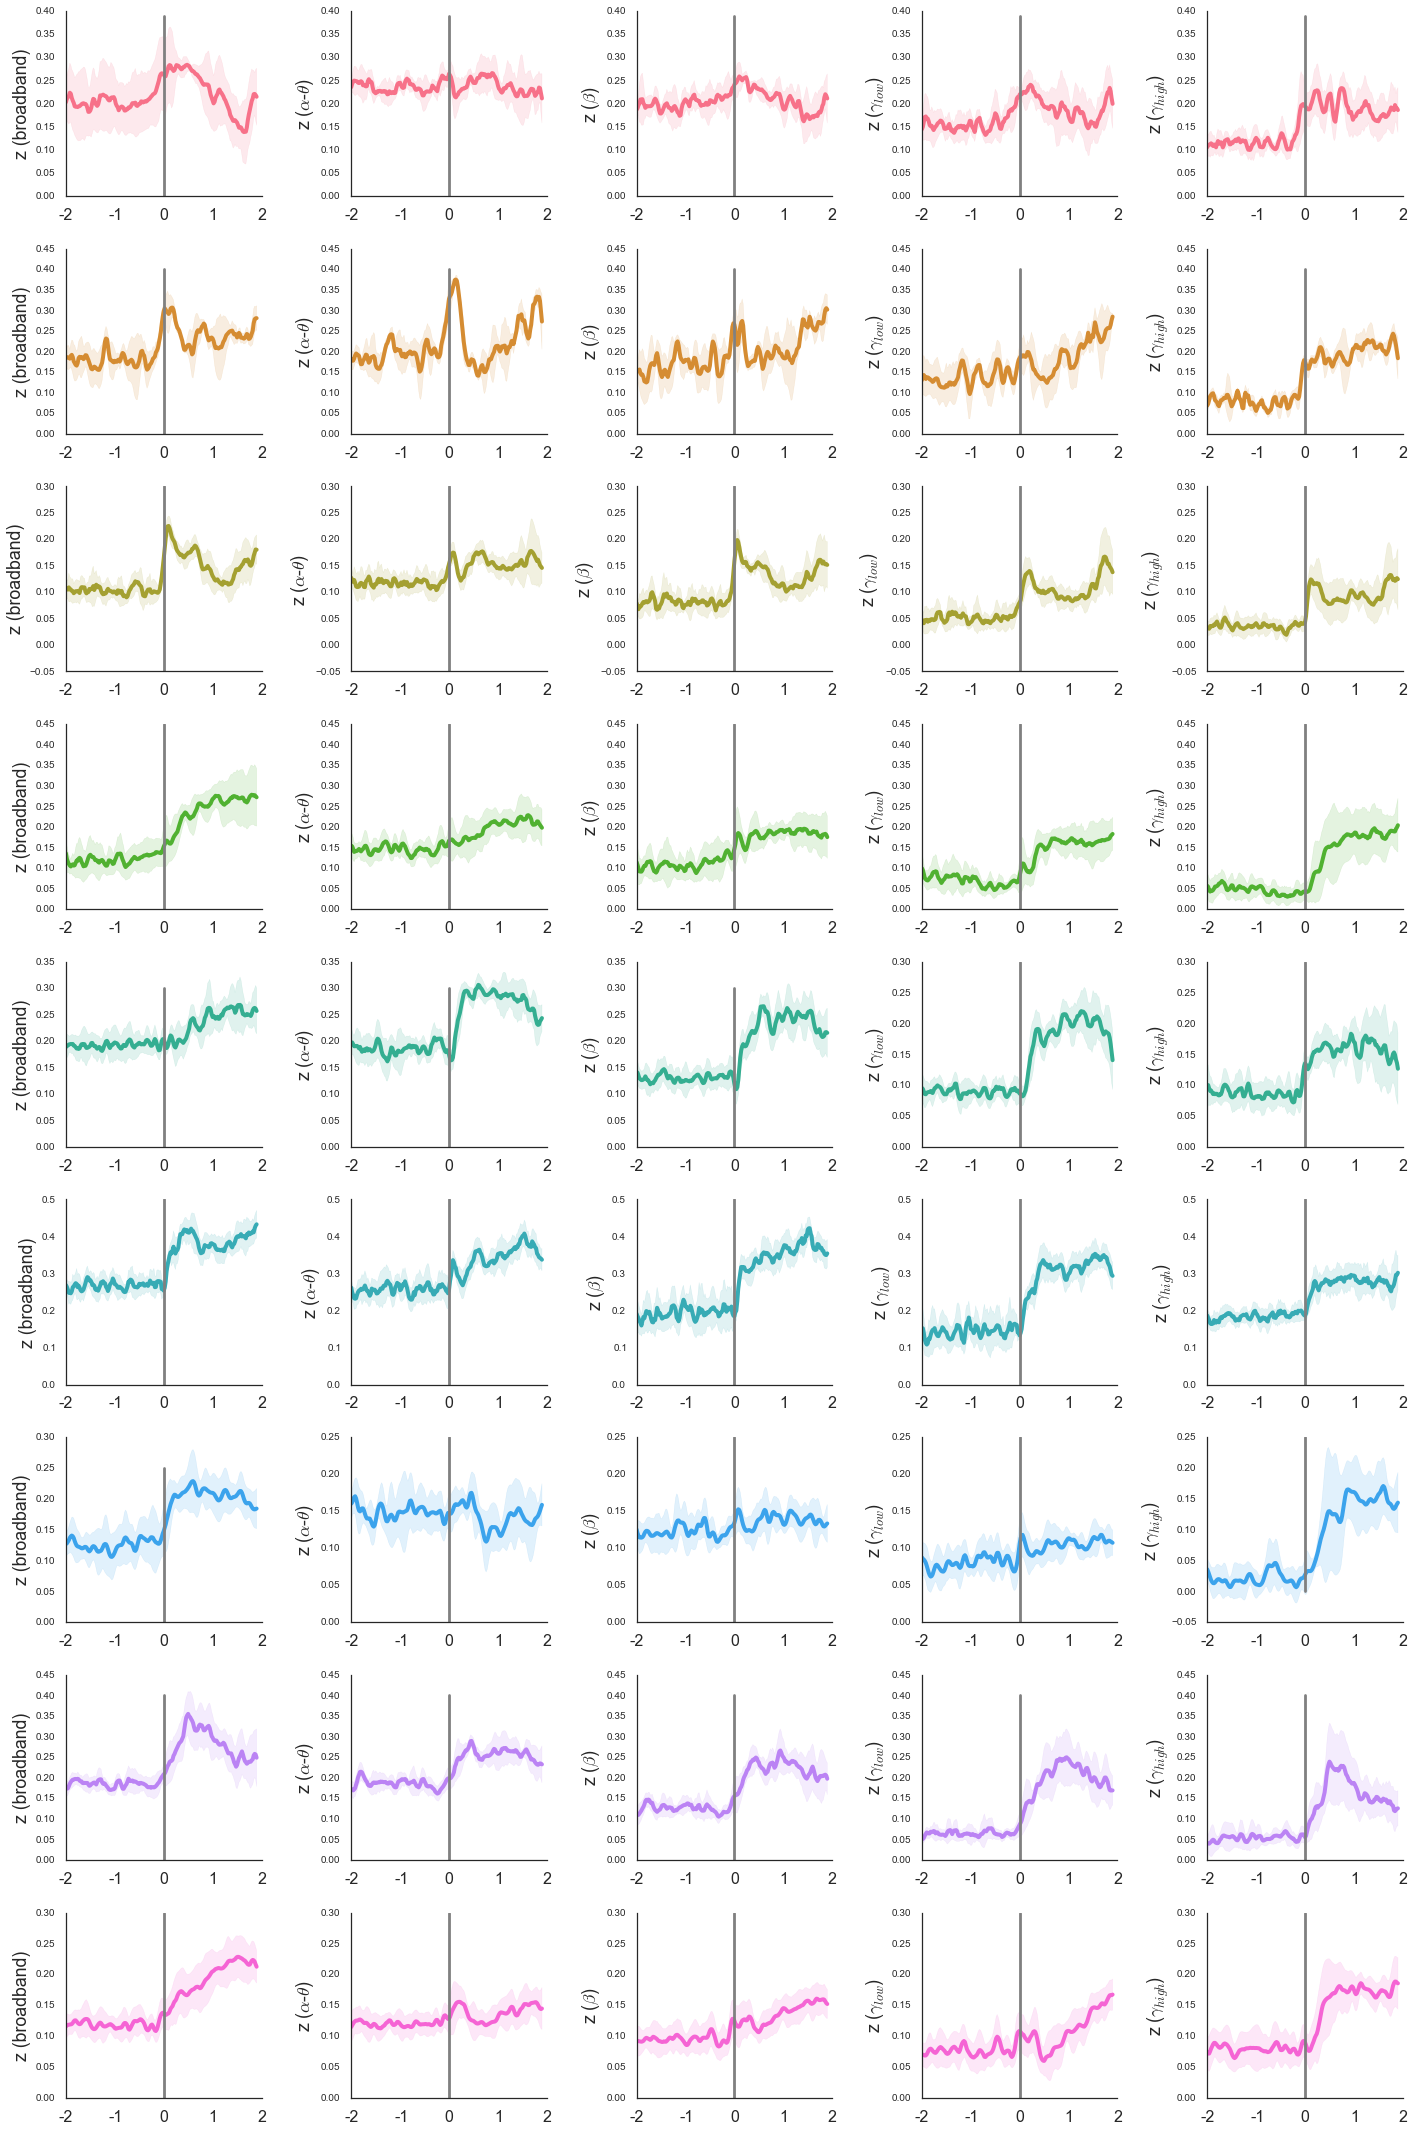

In [25]:
ymins=[0.0,0,-0.05,0,0,0,0,0,0,0]
ymaxs=[.39,.4,.3,.45,.3,.5,.25,.4,.3,.4]
smooth = 5
plt.figure(figsize=(20,30))
for freq_idx, freq in enumerate(freq_bands): 
    for sub_idx, subject in enumerate(subjects):
        plt.subplot(n_subs,5,freq_idx+5*sub_idx+1) 
        p = plt.plot(mysmoother(np.mean(r_temporal_dict[sub_idx][:, freq_idx,:],axis=0),smooth),linewidth=4,color=next(mycmap_iter),alpha=1)
        color = p[0].get_color()   
        plt.fill_between(range(n_samples-smooth+1), mysmoother(np.mean(r_temporal_dict[sub_idx][:, freq_idx,:],axis=0)-np.std(r_temporal_dict[sub_idx][:, freq_idx,:],axis=0),smooth) , mysmoother(np.mean(r_temporal_dict[sub_idx][:, freq_idx,:],axis=0)+np.std(r_temporal_dict[sub_idx][:, freq_idx,:],axis=0),smooth),  alpha = 0.15,color=color,interpolate=True) #,edgecolor='k'     
        plt.ylabel('z')   
        plt.ylabel('z (' + freq_titles_symbols_BB[freq_idx] + ')')
        ymin = ymins[sub_idx]
        ymax= ymaxs[sub_idx]
        plt.plot([n_samples/2,n_samples/2],[ymin, ymax],'grey' )  
        locs, labels = plt.xticks()
        plt.xticks(locs, ('-2', '-1','0', '1',  '2'))
        plt.yticks(fontsize=10)

    plt.tight_layout()
    sb.despine()

To quantify this subject-specific effect, we determined the most salient frequency band for each subject by identifying the band with the maximum mean increase in SC-FC coupling across seizure events.

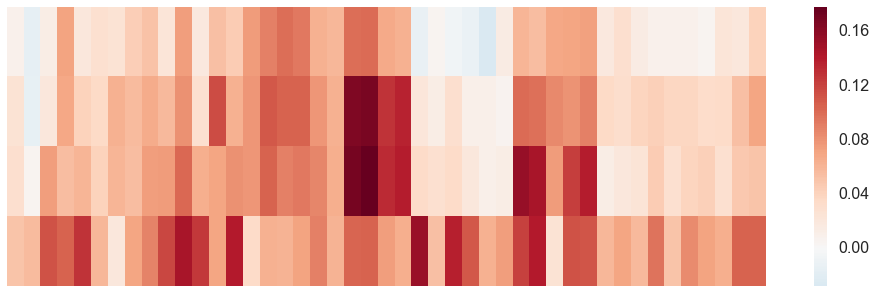

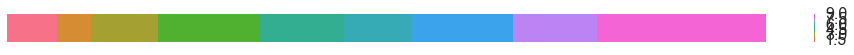

In [31]:
freq_titles_symbols_BB[0] = 'all'
plt.figure(figsize=(17,5))
sb.heatmap((r_ictal_mean[:,1:]- r_pre_mean[:,1:]).transpose(),cmap='RdBu_r',xticklabels=False,yticklabels=False,center=0)
#plt.savefig('Fig3d_i.pdf')
plt.figure(figsize=(17,0.5))
sb.heatmap([np.array(sub_assignment)],cmap=mycmap,xticklabels=False,yticklabels=False)
#plt.savefig('Fig3d_ii.pdf')

Finally, we characterized the within-subject similarity of the SC-FC time courses across all frequency bands. Using Euclidean distance as a measure of dissimilarity, we determined that the SC-FC time courses were significantly more similar within-patient than between-patient, indicating that the temporal dynamics of SC-FC coupling is stereotyped in each patient across seizure events.

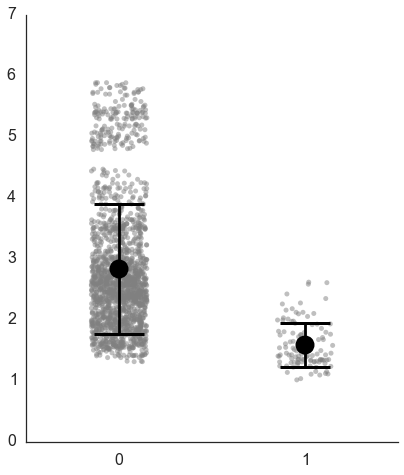

In [29]:
## similarity across ALL frequency bands
sb.set(context="poster", font_scale=1)
sb.set_style("white")

all_sz = np.concatenate([r_temporal_dict[key] for key in r_temporal_dict.keys()],axis=0)
all_sz = np.reshape(all_sz,[len(sub_assignment), len(freq_bands)*n_samples])   
simmat = distance.squareform(distance.pdist(all_sz, 'euclidean'))
np.fill_diagonal(simmat, np.nan)
all_intra_sims = []
all_extra_sims = []

for sub_idx, subject in enumerate(subjects):
    incl = np.arange(sz_idxs[sub_idx],sz_idxs[sub_idx+1])
    excl = [element for element in all_sz_idxs if element not in incl]

    simmat_sub = simmat[incl,:]
    intra_sims = np.unique(np.ndarray.flatten(simmat_sub[:,incl]))
    extra_sims = np.ndarray.flatten(simmat_sub[:,excl])

    all_intra_sims.append(intra_sims.tolist())
    all_extra_sims.append(extra_sims.tolist())

all_intra_sims_list = list(itertools.chain.from_iterable(all_intra_sims))
all_intra_sims_list = np.array(all_intra_sims_list)[~np.isnan(all_intra_sims_list)]
all_extra_sims_list = list(itertools.chain.from_iterable(all_extra_sims))

plt.figure(figsize=(6,7))
sb.stripplot(data=(np.array(all_extra_sims_list),np.array(all_intra_sims_list)),jitter=0.15,orient="v",alpha=0.5,size=5,zorder=1,color='grey')
plt.errorbar(0,np.mean(all_extra_sims_list),yerr=np.std(all_extra_sims_list), capsize=25, capthick=3,color='black')
plt.errorbar(1,np.mean(all_intra_sims_list),yerr=np.std(all_intra_sims_list), capsize=25, capthick=3,color='black')
sb.stripplot(data=([np.mean(np.array(all_extra_sims_list))],[np.mean(np.array(all_intra_sims_list))] ),size=19 ,color='k',marker="o")

plt.tight_layout()
sb.despine()

# 9. Virtual edge resection analysis
Given our finding that SC-FC coupling was significantly higher during ictal periods compared with preictal periods, we wanted to identify and characterize the structural edges that statistically accounted for this increase. After quantifying the contribution σ(i) of each edge on the SC-FC coupling, we mapped the contributor edges onto each subject’s brain to facilitate subject-specific characterization of SC-FC relationships. Furthermore, at the group level, we determined that contributor edges were predominantly short-range, as quantified by significantly shorter edge lengths in contributors compared with non-contributors, based on both geometric Euclidean distance and streamline distance. This finding held individually for each subject. Furthermore, within the contributor edges, we found that within each subject that higher contribution edges are shorter-range, both in terms of Euclidean distance and streamline length.


In [34]:
# Determine edge lengths for contributors and non-contributors, and for low, medium and high contributors
mymainfreq = 0
all_dist_drivers_sub = []
all_length_drivers_sub = []

all_dist_nondrivers_sub = []
all_length_nondrivers_sub = []

all_dist_drivers_sub1 = []
all_length_drivers_sub1 = []

all_dist_drivers_sub2 = []
all_length_drivers_sub2 = []

all_dist_drivers_sub3 = []
all_length_drivers_sub3 = []

for sub_idx, subject in enumerate(subjects):
    distmatline = mat2line(sio.loadmat('../Data/' + subjects[sub_idx] + '/structural.mat')['eucl_dist'])
    structmatline = mat2line(sio.loadmat('../Data/' + subjects[sub_idx] + '/structural.mat')['structmat'])
    lengthmatline = mat2line(sio.loadmat('../Data/' + subjects[sub_idx] + '/structural.mat')['lengthmat'])
    
    rscore_diff_matline = mat2line(np.mean([ mean_rscore_diff_dict[key] for key in mean_rscore_diff_dict.keys() if key[0] == sub_idx and key[2] == mymainfreq],axis=0))
    rscore_ictal_matline = mat2line(np.mean([ mean_rscore_ictal_dict[key] for key in mean_rscore_ictal_dict.keys() if key[0] == sub_idx and key[2] == mymainfreq],axis=0))
    
    rscore_diff_matline[structmatline ==0] = 0
    rscore_diff_matline[rscore_ictal_matline <=0] = 0
    rscore_diff_matline[rscore_diff_matline <= 0] = 0

    is_driver = np.array(structmatline >0) & np.array(rscore_diff_matline > 0) & np.array(rscore_ictal_matline > 0)
    is_nondriver = np.array(structmatline >0) & (np.array(rscore_diff_matline <= 0) | np.array(rscore_ictal_matline <= 0))
    
    dist_drivers = distmatline[is_driver]
    dist_nondrivers = distmatline[is_nondriver]
    
    length_drivers = lengthmatline[is_driver]
    length_nondrivers = lengthmatline[is_nondriver]
    
    cont_drivers = rscore_diff_matline[is_driver]
    cont_nondrivers = rscore_diff_matline[is_nondriver]
    
    tert1 = np.percentile(cont_drivers, 33.3333)
    tert2 = np.percentile(cont_drivers, 66.6666)
    tert3 = np.percentile(cont_drivers, 100)
    
    lowbin= np.array(cont_drivers <= tert1)
    midbin= np.array(cont_drivers > tert1) & np.array(cont_drivers <= tert2 )
    highbin = np.array(cont_drivers > tert2 ) & np.array(cont_drivers <= tert3 )

    all_dist_drivers_sub.append(np.mean(dist_drivers))
    all_dist_nondrivers_sub.append(np.mean(dist_nondrivers))
    
    all_length_drivers_sub.append(np.mean(length_drivers))
    all_length_nondrivers_sub.append(np.mean(length_nondrivers))

    all_dist_drivers_sub1.append(np.mean(dist_drivers[lowbin]))
    all_length_drivers_sub1.append(np.mean(length_drivers[lowbin]))
        
    all_dist_drivers_sub2.append(np.mean(dist_drivers[midbin]))
    all_length_drivers_sub2.append(np.mean(length_drivers[midbin]))
        
    all_dist_drivers_sub3.append(np.mean(dist_drivers[highbin]))
    all_length_drivers_sub3.append(np.mean(length_drivers[highbin]))

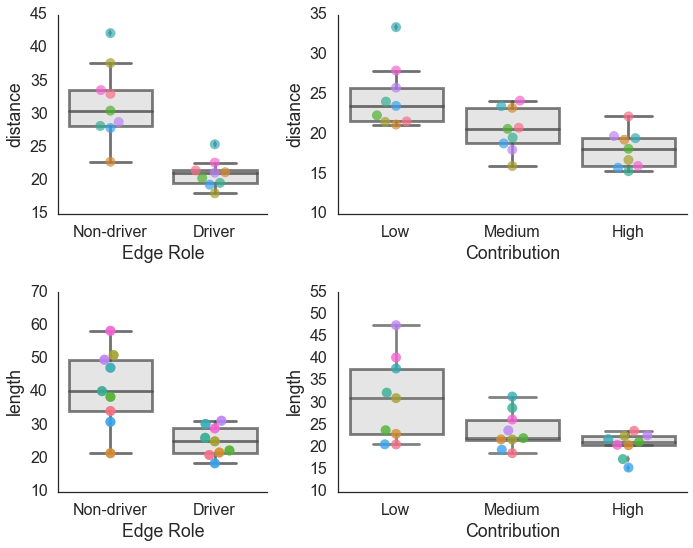

In [36]:
# Plot results
df_dist =pd.DataFrame({"Non-driver":np.array(all_dist_nondrivers_sub),"Driver":np.array(all_dist_drivers_sub),"Low":np.array(all_dist_drivers_sub1),"Medium":np.array(all_dist_drivers_sub2),"High":np.array(all_dist_drivers_sub3),"Subject":np.arange(9)+1})
df_dist = pd.melt(df_dist, "Subject", var_name="Edge Role")
df_length =pd.DataFrame({"Non-driver":np.array(all_length_nondrivers_sub),"Driver":np.array(all_length_drivers_sub),"Low":np.array(all_length_drivers_sub1),"Medium":np.array(all_length_drivers_sub2),"High":np.array(all_length_drivers_sub3),"Subject":np.arange(9)+1})
df_length = pd.melt(df_length, "Subject", var_name="Edge Role")

fig = plt.figure(3,figsize=(10,8))
gridspec.GridSpec(2,5)

plt.subplot2grid((2,5), (0,0),colspan=2, rowspan=1)
ax = sb.boxplot(data=df_dist,x="Edge Role",y="value",color='grey',order =["Non-driver","Driver"])
for i, patch in enumerate(ax.artists):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    patch.set_edgecolor((0, 0, 0, .5))
ax = sb.swarmplot(data=df_dist, x="Edge Role",y="value", order =["Non-driver","Driver"],hue="Subject",palette=mycmap,size=10)
plt.setp(ax.collections, alpha=.7)
plt.setp(ax.lines, alpha=.8)
plt.ylabel('distance')
locs, labels = plt.xticks()
ax.legend_.remove()
sb.despine()   

plt.subplot2grid((2,5), (0,2), colspan=3, rowspan=1)
ax = sb.boxplot(data=df_dist,x="Edge Role",y="value",color='grey',order =["Low","Medium","High"])
for i, patch in enumerate(ax.artists):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    patch.set_edgecolor((0, 0, 0, .5))
ax = sb.swarmplot(data=df_dist, x="Edge Role",y="value", order =["Low","Medium","High"],hue="Subject",palette=mycmap,size=10)
plt.setp(ax.collections, alpha=.7)
plt.setp(ax.lines, alpha=.8)
plt.xlabel('Contribution')
plt.ylabel('distance')
locs, labels = plt.xticks()
ax.legend_.remove()
sb.despine() 

plt.subplot2grid((2,5), (1,0),colspan=2, rowspan=1)
ax = sb.boxplot(data=df_length,x="Edge Role",y="value",color='grey',order =["Non-driver","Driver",])
for i, patch in enumerate(ax.artists):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    patch.set_edgecolor((0, 0, 0, .5))
    ax = sb.swarmplot(data=df_length, x="Edge Role",y="value", order =["Non-driver","Driver"],hue="Subject",palette=mycmap,size=10)
plt.setp(ax.collections, alpha=.7)
plt.setp(ax.lines, alpha=.8)        
plt.ylabel('length')
locs, labels = plt.xticks()
ax.legend_.remove()
sb.despine() 

plt.subplot2grid((2,5), (1,2), colspan=3, rowspan=1)
ax = sb.boxplot(data=df_length,x="Edge Role",y="value",color='grey',order =["Low","Medium","High"])
plt.xlabel('Contribution')
for i, patch in enumerate(ax.artists):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    patch.set_edgecolor((0, 0, 0, .5))
ax2 = sb.swarmplot(data=df_length, x="Edge Role", y="value", order =["Low","Medium","High"],hue="Subject",palette=mycmap,size=10)
plt.setp(ax2.collections, alpha=.8)
plt.setp(ax2.lines, alpha=.7)
plt.xlabel('Contribution')
plt.ylabel('length')
locs, labels = plt.xticks()
ax.legend_.remove()
sb.despine() 

fig.tight_layout()


# 9. Statistical Analysis

Here we save some csv files for further statistical analysis in R

In [ ]:
# This is for linear mixed model analysis
for freq_idx, freq in enumerate(freq_titles): 
    if regress_distance == 'yes':
        myfilename = 'data_for_lme_' + freq + '_regressed.csv'
    else:
        myfilename ='data_for_lme_' + freq + '.csv'
    d = {'ictal_v_pre': np.array(r_ictal_mean[:,freq_idx])-np.array(r_pre_mean[:,freq_idx]),'ictal_v_inter': np.array(r_ictal_mean[:,freq_idx])-np.array(r_interictal_mean[:,freq_idx]),'pre_v_inter': np.array(r_pre_mean[:,freq_idx])-np.array(r_interictal_mean[:,freq_idx]), 'subject': sub_assignment}
    df_r = pd.DataFrame(data=d)
    df_r.to_csv(myfilename,index=False)

In [ ]:
# This is for the permutational MANOVA
np.savetxt("simmat_for_R.csv", simmat, delimiter=",")